In [1]:
import math
import pickle

import pandas as pd
import numpy as np
import os.path as op
import pylab as pl

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import rdMolDescriptors

# Load data

In [ ]:
novel_df = pd.read_csv('smiles_with_predicted_properties.csv')
ref_df = pd.read_csv('')

In [2]:
# novel_df = pd.read_pickle('backups/novel_df.pickle')
# minor_class_df = pd.read_pickle('backups/minor_class_df.pickle')
# corrected_df = pd.read_pickle('backups/smiles_corrected.pickle')

# print(novel_df.columns)
# print(minor_class_df.columns)
# print(corrected_df.columns)
# print(len(novel_df))
# print(len(minor_class_df))
# print(len(corrected_df))

Index(['SMILES_generated', 'mol', 'synthetic_accessibility_score',
       'molecular_weight', 'logP', 'TPSA'],
      dtype='object')
Index(['SMILES_minor', 'mol', 'synthetic_accessibility_score',
       'molecular_weight', 'logP', 'TPSA'],
      dtype='object')
Index(['with_errors', 'corrected', 'synthetic_accessibility_score',
       'molecular_weight', 'logP', 'TPSA'],
      dtype='object')
5836
189936
12040


In [3]:
corrected_df.head()

,with_errors,corrected,synthetic_accessibility_score,molecular_weight,logP,TPSA
0,Oc1cc(CN2CCC(C2Cc2cccnH]n2)ccc1Cl,Oc1cc(CN2CCCCCC2c2ccc[nH]2)ccc1Cl,2.857206,304.134241,4.49100,39.26
1,CC(CCNC(=O)CSc1nc(cc(n1)C(F)(F)F)-c1ccc(OC)cc1,CCCCNCC(=O)CSc1nc(cc(n1)C(F)(F)F)-c1ccc(OC)cc1,2.468444,413.138483,4.22190,64.11
2,COc1ccc(ccc1)-c1ncccc(C)c(NC(=O)c2cccc3)cc2n1,COc1ccc(cc1)-c1nc2ccc(C)c(NC(=O)c3ccco3)cc2n1,2.100574,359.126991,4.41072,77.25
3,(CCOc1ccc(Br)cc1C(O)=O,CCOCc1ccc(F)cc1C(O)=O,1.890565,198.069222,2.06040,46.53
4,c(Cc1ccc(cc)c(n1nnn11-c1ccccc1,Cl.Cc1ccc(c(O)c1)-n1nnn1-c1ccccc1,2.737724,276.077789,2.49382,55.87


# Sanitize

In [ ]:
def sanitize(row):
    m = Chem.MolFromSmiles(row)
    if m:
        try:
            Chem.SanitizeMol(m)
            return m
        except Exception as e:
            print(e)
            return None

In [ ]:
novel_df['corrected_mol'] = novel_df.SMILES_generated.apply(sanitize)
minor_class_df['corrected_mol'] = minor_class_df.SMILES_minor.apply(sanitize)
corrected_df['corrected_mol'] = corrected_df.corrected.apply(sanitize)

In [ ]:
novel_df = novel_df.dropna()
minor_class_df = minor_class_df.dropna()
corrected_df = corrected_df.dropna()

In [ ]:
print(len(novel_df))
print(len(minor_class_df))
print(len(corrected_df))

# ChEMBL search

In [22]:
import chembl_webresource_client

ModuleNotFoundError: No module named 'chembl_webresource_client'

In [21]:
from chembl_webresource_client.new_client import new_client

similarity = new_client.similarity
res = similarity.filter(smiles="CO[C@@H](CCC#C\C=C/CCCC(C)CCCCC=C)C(=O)[O-]", similarity=85)

ModuleNotFoundError: No module named 'chembl_webresource_client'

# Molecular descriptors

# Synthetic accessibility score

In [7]:
_fscores = None


def readFragmentScores(name='fpscores'):
    import gzip
    global _fscores
    # generate the full path filename:
#     if name == "fpscores":
#         name = op.join(op.dirname(__file__), name)
    _fscores = pickle.load(gzip.open('%s.pkl.gz' % name))
    outDict = {}
    for i in _fscores:
        for j in range(1, len(i)):
            outDict[i[j]] = float(i[0])
    _fscores = outDict

In [8]:
def numBridgeheadsAndSpiro(mol, ri=None):
    nSpiro = rdMolDescriptors.CalcNumSpiroAtoms(mol)
    nBridgehead = rdMolDescriptors.CalcNumBridgeheadAtoms(mol)
    return nBridgehead, nSpiro


def calculateScore(smiles_string):
    if _fscores is None:
        readFragmentScores()
    
    m = Chem.MolFromSmiles(smiles_string)
    # fragment score
    fp = rdMolDescriptors.GetMorganFingerprint(m, 2)  # <- 2 is the *radius* of the circular fingerprint
    fps = fp.GetNonzeroElements()
    score1 = 0.
    nf = 0
    for bitId, v in fps.items():
        nf += v
        sfp = bitId
        score1 += _fscores.get(sfp, -4) * v
    score1 /= nf

    # features score
    nAtoms = m.GetNumAtoms()
    nChiralCenters = len(Chem.FindMolChiralCenters(m, includeUnassigned=True))
    ri = m.GetRingInfo()
    nBridgeheads, nSpiro = numBridgeheadsAndSpiro(m, ri)
    nMacrocycles = 0
    
    for x in ri.AtomRings():
        if len(x) > 8:
            nMacrocycles += 1

    sizePenalty = nAtoms**1.005 - nAtoms
    stereoPenalty = math.log10(nChiralCenters + 1)
    spiroPenalty = math.log10(nSpiro + 1)
    bridgePenalty = math.log10(nBridgeheads + 1)
    macrocyclePenalty = 0.
    # ---------------------------------------
    # This differs from the paper, which defines:
    #  macrocyclePenalty = math.log10(nMacrocycles+1)
    # This form generates better results when 2 or more macrocycles are present
    if nMacrocycles > 0:
        macrocyclePenalty = math.log10(2)

    score2 = 0. - sizePenalty - stereoPenalty - spiroPenalty - bridgePenalty - macrocyclePenalty

    # correction for the fingerprint density
    # not in the original publication, added in version 1.1
    # to make highly symmetrical molecules easier to synthetise
    score3 = 0.
    if nAtoms > len(fps):
        score3 = math.log(float(nAtoms) / len(fps)) * .5

    sascore = score1 + score2 + score3

    # need to transform "raw" value into scale between 1 and 10
    min = -4.0
    max = 2.5
    sascore = 11. - (sascore - min + 1) / (max - min) * 9.
    # smooth the 10-end
    if sascore > 8.:
        sascore = 8. + math.log(sascore + 1. - 9.)
    if sascore > 10.:
        sascore = 10.0
    elif sascore < 1.:
        sascore = 1.0

    return sascore

In [9]:
corrected_df['synthetic_accessibility_score'] = corrected_df.corrected.apply(calculateScore)

# Molecular weight

In [10]:
from rdkit.Chem.Descriptors import ExactMolWt

def get_mol_weight_from_smiles(row):
    m = Chem.MolFromSmiles(row)
    if m:
        try:
            return ExactMolWt(Chem.AddHs(m))
        except Exception as e:
            print('row', row, e)

In [11]:
corrected_df['molecular_weight'] = corrected_df.corrected.apply(get_mol_weight_from_smiles)

row Cc1ccc(cc1)-c1nn(CCC(=O)NCc2ccncc2)(=O)c2ccccc12 Sanitization error: Explicit valence for atom # 9 N, 5, is greater than permitted
row CC(C)c1ccc(cc1)-c1csc2ncn(-c3ccccc3)(=O)c12 Sanitization error: Explicit valence for atom # 15 N, 5, is greater than permitted
row CSCCC(NCn1ccc2ccccc12)CC(=O)Cc1nn(C(C)CC)(=O)c2ccccc12 Sanitization error: Explicit valence for atom # 22 N, 5, is greater than permitted


# logP

In [12]:
from rdkit.Chem.Crippen import MolLogP

def get_logp_from_smiles(row):
    m = Chem.MolFromSmiles(row)
    if m:
        try:
            return MolLogP(Chem.AddHs(m))
        except Exception as e:
            print('row', row, e)

In [13]:
corrected_df['logP'] = corrected_df.corrected.apply(get_logp_from_smiles)

row Cc1ccc(cc1)-c1nn(CCC(=O)NCc2ccncc2)(=O)c2ccccc12 Sanitization error: Explicit valence for atom # 9 N, 5, is greater than permitted
row CC(C)c1ccc(cc1)-c1csc2ncn(-c3ccccc3)(=O)c12 Sanitization error: Explicit valence for atom # 15 N, 5, is greater than permitted
row CSCCC(NCn1ccc2ccccc12)CC(=O)Cc1nn(C(C)CC)(=O)c2ccccc12 Sanitization error: Explicit valence for atom # 22 N, 5, is greater than permitted


# TPSA

In [14]:
from rdkit.Chem.rdMolDescriptors import CalcTPSA

def get_tpsa_from_smiles(row):
    m = Chem.MolFromSmiles(row)
    if m:
        try:
            return CalcTPSA(Chem.AddHs(m))
        except Exception as e:
            print('row', row, e)

In [15]:
corrected_df['TPSA'] = corrected_df.corrected.apply(get_tpsa_from_smiles)

row Cc1ccc(cc1)-c1nn(CCC(=O)NCc2ccncc2)(=O)c2ccccc12 Sanitization error: Explicit valence for atom # 9 N, 5, is greater than permitted
row CC(C)c1ccc(cc1)-c1csc2ncn(-c3ccccc3)(=O)c12 Sanitization error: Explicit valence for atom # 15 N, 5, is greater than permitted
row CSCCC(NCn1ccc2ccccc12)CC(=O)Cc1nn(C(C)CC)(=O)c2ccccc12 Sanitization error: Explicit valence for atom # 22 N, 5, is greater than permitted


# Save results

In [18]:
print(corrected_df.columns)

Index(['with_errors', 'corrected', 'synthetic_accessibility_score',
       'molecular_weight', 'logP', 'TPSA'],
      dtype='object')


In [20]:
corrected_df.to_pickle('backups/smiles_corrected.pickle')

# Plot results

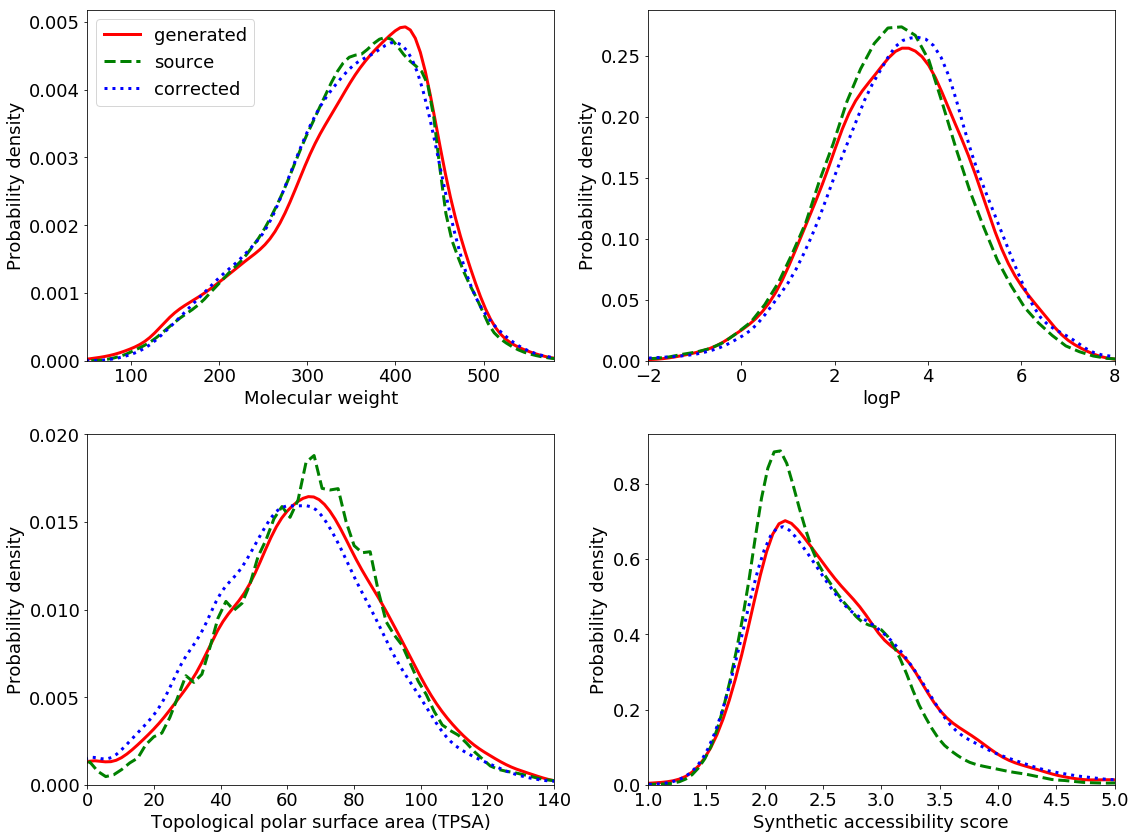

In [70]:
from matplotlib import pyplot
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['font.size'] = 18
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18

fig, ax = pyplot.subplots(nrows=2, ncols=2, figsize=(16,12))

sns.distplot(novel_df.molecular_weight, hist = False, kde = True, kde_kws = {'linewidth': 3}, color='red', label="generated", ax=ax[0,0])
sns.distplot(minor_class_df.molecular_weight, hist = False, kde = True, kde_kws = {'linestyle':'dashed', 'linewidth': 3}, label="source", color='green', ax=ax[0,0])
sns.distplot(corrected_df.molecular_weight, hist = False, kde = True, kde_kws = {'linestyle':'dotted', 'linewidth': 3}, label="corrected", color='blue', ax=ax[0,0])
ax[0,0].set(xlabel='Molecular weight', ylabel='Probability density')
ax[0,0].set_xlim(50, 580)

sns.distplot(novel_df.logP, hist = False, kde = True, kde_kws = {'linewidth': 3}, color='red', ax=ax[0,1])
sns.distplot(minor_class_df.logP, hist = False, kde = True, kde_kws = {'linestyle':'dashed', 'linewidth': 3}, color='green', ax=ax[0,1])
sns.distplot(corrected_df.logP, hist = False, kde = True, kde_kws = {'linestyle':'dotted', 'linewidth': 3}, color='blue', ax=ax[0,1])
ax[0,1].set(xlabel='logP', ylabel='Probability density')
ax[0,1].set_xlim(-2, 8)

sns.distplot(novel_df.TPSA, hist = False, kde = True, kde_kws = {'linewidth': 3}, color='red', ax=ax[1,0])
sns.distplot(minor_class_df.TPSA, hist = False, kde = True, kde_kws = {'linestyle':'dashed', 'linewidth': 3}, color='green', ax=ax[1,0])
sns.distplot(corrected_df.TPSA, hist = False, kde = True, kde_kws = {'linestyle':'dotted', 'linewidth': 3}, color='blue', ax=ax[1,0])
ax[1,0].set(xlabel='Topological polar surface area (TPSA)', ylabel='Probability density')
ax[1,0].set_xlim(0, 140)
ax[1,0].set_ylim(0, 0.02)
ax[1,0].set_yticks([0, 0.005, 0.01, 0.015, 0.02])

sns.distplot(novel_df.synthetic_accessibility_score, hist=False, kde = True, kde_kws = {'linewidth': 3}, color='red', ax=ax[1,1])
sns.distplot(minor_class_df.synthetic_accessibility_score, hist=False, kde = True, kde_kws = {'linestyle':'dashed', 'linewidth': 3}, color='green', ax=ax[1,1])
sns.distplot(corrected_df.synthetic_accessibility_score, hist=False, kde = True, kde_kws = {'linestyle':'dotted', 'linewidth': 3}, color='blue', ax=ax[1,1])
ax[1,1].set(xlabel='Synthetic accessibility score', ylabel='Probability density')
ax[1,1].set_xlim(1, 5)

plt.tight_layout()

Text(0, 0.5, 'Probability density')

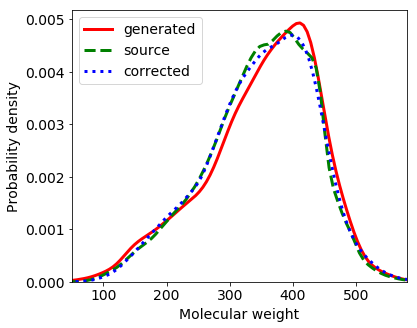

In [78]:
fig = plt.figure(figsize=(6,5))

plt.rcParams['font.size'] = 14
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14

sns.distplot(novel_df.molecular_weight, hist = False, kde = True, kde_kws = {'linewidth': 3}, color='red', label="generated")
sns.distplot(minor_class_df.molecular_weight, hist=False, kde = True, kde_kws = {'linestyle':'dashed', 'linewidth': 3}, color='green', label="source")
sns.distplot(corrected_df.molecular_weight, hist = False, kde = True, kde_kws = {'linestyle':'dotted', 'linewidth': 3}, label="corrected", color='blue')
pl.xlim(50, 580)
pl.xlabel('Molecular weight')
pl.ylabel("Probability density")

Text(0, 0.5, 'Probability density')

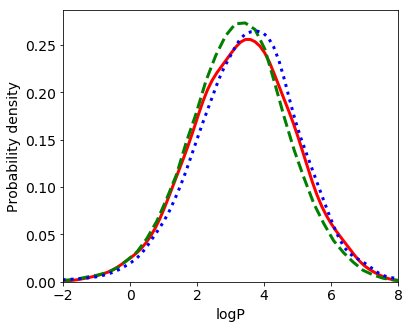

In [81]:
fig = plt.figure(figsize=(6,5))

plt.rcParams['font.size'] = 14
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14

sns.distplot(novel_df.logP, hist = False, kde = True, kde_kws = {'linewidth': 3}, color='red')
sns.distplot(minor_class_df.logP, hist=False, kde = True, kde_kws = {'linestyle':'dashed', 'linewidth': 3}, color='green')
sns.distplot(corrected_df.logP, hist = False, kde = True, kde_kws = {'linestyle':'dotted', 'linewidth': 3}, color='blue')
pl.xlim(-2, 8)
pl.xlabel('logP')
pl.ylabel("Probability density")

Text(0, 0.5, 'Probability density')

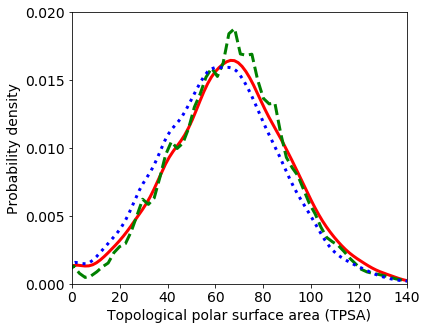

In [82]:
fig = plt.figure(figsize=(6,5))

plt.rcParams['font.size'] = 14
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14

sns.distplot(novel_df.TPSA, hist = False, kde = True, kde_kws = {'linewidth': 3}, color='red')
sns.distplot(minor_class_df.TPSA, hist=False, kde = True, kde_kws = {'linestyle':'dashed', 'linewidth': 3}, color='green')
sns.distplot(corrected_df.TPSA, hist = False, kde = True, kde_kws = {'linestyle':'dotted', 'linewidth': 3}, color='blue')
pl.xlim(0, 140)
pl.ylim(0, 0.02)
pl.yticks([0, 0.005, 0.01, 0.015, 0.02])
pl.xlabel('Topological polar surface area (TPSA)')
pl.ylabel("Probability density")

# SAS histogram

Text(0, 0.5, 'Probability density')

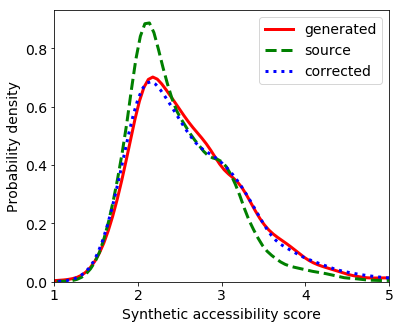

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

fig = plt.figure(figsize=(6,5))

plt.rcParams['font.size'] = 14
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14

sns.distplot(novel_df.synthetic_accessibility_score, hist = False, kde = True, kde_kws = {'linewidth': 3}, color='red', label="generated")
sns.distplot(minor_class_df.synthetic_accessibility_score, hist=False, kde = True, kde_kws = {'linestyle':'dashed', 'linewidth': 3}, color='green', label="source")
sns.distplot(corrected_df.synthetic_accessibility_score, hist = False, kde = True, kde_kws = {'linestyle':'dotted', 'linewidth': 3}, label="corrected", color='blue')
pl.xlim(1, 5)
pl.xlabel("Synthetic accessibility score")
pl.ylabel("Probability density")

Text(0, 0.5, 'Probability density')

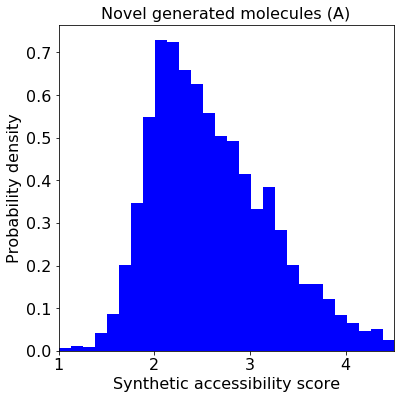

In [41]:
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (6, 6)
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['font.size'] = 16
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
novel_df.synthetic_accessibility_score.hist(
    bins=48, 
    align='mid',
    density=True, 
    grid=False,
    color='blue'
)
pl.xlim(1, 4.5)
pl.title("Novel generated molecules (A)")
pl.xlabel("Synthetic accessibility score")
pl.ylabel("Probability density")

Text(0, 0.5, 'Probability density')

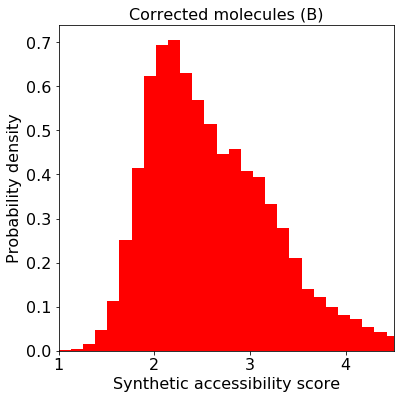

In [42]:
corrected_df.synthetic_accessibility_score.hist(
    bins=48, 
    align='mid',
    density=True, 
    grid=False,
    color='red'
)
pl.xlim(1, 4.5)
pl.title("Corrected molecules (B)")
pl.xlabel("Synthetic accessibility score")
pl.ylabel("Probability density")

In [12]:
print('corrected mean', minor_class_df.synthetic_accessibility_score.mean())
print('corrected median', minor_class_df.synthetic_accessibility_score.median())
print('corrected mean', corrected_df.synthetic_accessibility_score.mean())
print('corrected median', corrected_df.synthetic_accessibility_score.median())
print('generated mean', novel_df.synthetic_accessibility_score.mean())
print('generated median', novel_df.synthetic_accessibility_score.median())

corrected mean 2.4880100336429836
corrected median 2.3694462515439083
corrected mean 2.625994009189228
corrected median 2.4889649477990083
generated mean 2.6291337992989314
generated median 2.506272855358497


# Substructure Search

In [8]:
print(corrected_df.columns)

Index(['with_errors', 'corrected', 'synthetic_accessibility_score',
       'molecular_weight', 'logP', 'TPSA', 'corrected_mol'],
      dtype='object')


In [9]:
corrected_df['mol'] = corrected_df.corrected.apply(Chem.MolFromSmiles)

In [48]:
def get_ring_info(mol):
#     mol = Chem.AddHs(mol)
    rc = mol.GetRingInfo().NumRings()
    nfrags = len(Chem.GetMolFrags(mol))
    ec = mol.GetNumBonds() - mol.GetNumAtoms() + nfrags
    return max(rc, ec)

In [49]:
corrected_df['rings'] = corrected_df.mol.apply(get_ring_info)

In [50]:
l = len(corrected_df)

print(len(corrected_df[corrected_df.rings == 0]) / l * 100)
print(len(corrected_df[corrected_df.rings == 1]) / l * 100)
print(len(corrected_df[corrected_df.rings == 2]) / l * 100)
print(len(corrected_df[corrected_df.rings == 3]) / l * 100)
print(len(corrected_df[corrected_df.rings == 4]) / l * 100)
print(len(corrected_df[corrected_df.rings > 4]) / l * 100)

2.0598006644518274
9.044850498338871
24.559800664451828
31.75249169435216
26.27076411960133
6.312292358803987


In [51]:
def contains_nitrogen(smiles):
    smiles = smiles.lower()
    if 'n' in smiles:
        return 1
    else:
        return 0

In [52]:
corrected_df['contains_nitrogen'] = corrected_df.corrected.apply(contains_nitrogen)

In [53]:
def contains_sulfur(smiles):
    smiles = smiles.lower()
    if 's' in smiles:
        return 1
    else:
        return 0

In [54]:
corrected_df['contains_sulfur'] = corrected_df.corrected.apply(contains_sulfur)

In [55]:
def contains_oxygen(smiles):
    smiles = smiles.lower()
    if 'o' in smiles:
        return 1
    else:
        return 0

In [57]:
corrected_df['contains_oxygen'] = corrected_df.corrected.apply(contains_oxygen)

In [56]:
halogens = ['f', 'cl', 'br', 'i', 'at']

def contains_halogen(smiles):
    smiles = smiles.lower()
    if any(hal in smiles for hal in halogens):
        return 1
    else:
        return 0

In [58]:
corrected_df['contains_halogen'] = corrected_df.corrected.apply(contains_halogen)

In [59]:
print(len(corrected_df[corrected_df.contains_nitrogen == 1]) / l * 100)
print(len(corrected_df[corrected_df.contains_sulfur == 1]) / l * 100)
print(len(corrected_df[corrected_df.contains_oxygen == 1]) / l * 100)
print(len(corrected_df[corrected_df.contains_halogen == 1]) / l * 100)
print(len(corrected_df[(corrected_df.contains_nitrogen == 0) & (corrected_df.contains_oxygen == 0) & (corrected_df.contains_sulfur == 0)]) / l * 100)

91.7358803986711
35.946843853820596
91.51162790697674
39.260797342192696
0.9966777408637874


In [60]:
from rdkit.Chem.rdMolDescriptors import CalcNumSpiroAtoms

def get_number_of_spiro_atoms(smiles):
    return CalcNumSpiroAtoms(Chem.MolFromSmiles(smiles))

In [61]:
corrected_df['spiro_atoms'] = corrected_df.corrected.apply(get_number_of_spiro_atoms)

In [62]:
print(len(corrected_df[corrected_df.spiro_atoms > 0]) / l * 100)

1.935215946843854


In [63]:
from rdkit.Chem.rdMolDescriptors import CalcNumHeterocycles

def get_number_of_heterocycles(smiles):
    return CalcNumHeterocycles(Chem.MolFromSmiles(smiles))

In [64]:
corrected_df['heterocycles'] = corrected_df.corrected.apply(get_number_of_heterocycles)

In [65]:
print(len(corrected_df[corrected_df.heterocycles > 0]) / l * 100)

73.62126245847176


# Common functional groups

In [7]:
from rdkit import Chem
from collections import namedtuple

def merge(mol, marked, aset):
    bset = set()
    for idx in aset:
        atom = mol.GetAtomWithIdx(idx)
        for nbr in atom.GetNeighbors():
            jdx = nbr.GetIdx()
            if jdx in marked:
                marked.remove(jdx)
                bset.add(jdx)
    if not bset:
        return
    merge(mol, marked, bset)
    aset.update(bset)

# atoms connected by non-aromatic double or triple bond to any heteroatom
# c=O should not match (see fig1, box 15).  I think using A instead of * should sort that out?
PATT_DOUBLE_TRIPLE = Chem.MolFromSmarts('A=,#[!#6]')
# atoms in non aromatic carbon-carbon double or triple bonds
PATT_CC_DOUBLE_TRIPLE = Chem.MolFromSmarts('C=,#C')
# acetal carbons, i.e. sp3 carbons connected to tow or more oxygens, nitrogens or sulfurs; these O, N or S atoms must have only single bonds
PATT_ACETAL = Chem.MolFromSmarts('[CX4](-[O,N,S])-[O,N,S]')
# all atoms in oxirane, aziridine and thiirane rings
PATT_OXIRANE_ETC = Chem.MolFromSmarts('[O,N,S]1CC1')

PATT_TUPLE = (PATT_DOUBLE_TRIPLE, PATT_CC_DOUBLE_TRIPLE, PATT_ACETAL, PATT_OXIRANE_ETC)

def identify_functional_groups(mol):
    marked = set()
    # mark all heteroatoms in a molecule, including halogens
    for atom in mol.GetAtoms():
        if atom.GetAtomicNum() not in (6,1): # would we ever have hydrogen?
            marked.add(atom.GetIdx())

    # mark the four specific types of carbon atom
    for patt in PATT_TUPLE:
        for path in mol.GetSubstructMatches(patt):
            for atomindex in path:
                marked.add(atomindex)

    # merge all connected marked atoms to a single FG
    groups = []
    while marked:
        grp = set([marked.pop()])
        merge(mol, marked, grp)
        groups.append(grp)

    # extract also connected unmarked carbon atoms
    ifg = namedtuple('IFG', ['atomIds', 'atoms', 'type'])
    ifgs = []
    for g in groups:
        uca = set()
        for atomidx in g:
            for n in mol.GetAtomWithIdx(atomidx).GetNeighbors():
                if n.GetAtomicNum() == 6:
                    uca.add(n.GetIdx())
        ifgs.append(ifg(atomIds=tuple(list(g)), atoms=Chem.MolFragmentToSmiles(mol, g, canonical=True), type=Chem.MolFragmentToSmiles(mol, g.union(uca),canonical=True)))
    return ifgs

In [8]:
def get_func_groups_from_smiles(smiles):
    m = Chem.MolFromSmiles(smiles)
    return identify_functional_groups(m)

In [9]:
%%time

novel_df['functional_groups'] = novel_df['SMILES_generated'].apply(get_func_groups_from_smiles)
minor_class_df['functional_groups'] = minor_class_df['SMILES_minor'].apply(get_func_groups_from_smiles)
corrected_df['functional_groups'] = corrected_df.corrected.apply(get_func_groups_from_smiles)

CPU times: user 4min 38s, sys: 2.1 s, total: 4min 40s
Wall time: 4min 40s


In [10]:
func_groups = dict()

for index, row in novel_df.iterrows():
    for ifg in row['functional_groups']:
        if ifg.type in func_groups.keys():
            func_groups[ifg.type] += 1
        else:
            func_groups[ifg.type] = 1

In [11]:
func_groups = sorted(func_groups.items(), key=lambda kv: kv[1], reverse=True)

In [12]:
func_groups_total = 0

for k, v in func_groups:
    func_groups_total += v

In [13]:
print(func_groups_total)

24730


In [14]:
def count_to_frequency(count):
    return count / func_groups_total

In [15]:
func_groups_freq = dict((k, count_to_frequency(v)) for k, v in func_groups)

In [16]:
func_groups_undersampled = dict()

for index, row in minor_class_df.iterrows():
    for ifg in row['functional_groups']:
        if ifg.type in func_groups_undersampled.keys():
            func_groups_undersampled[ifg.type] += 1
        else:
            func_groups_undersampled[ifg.type] = 1
            
func_groups_undersampled = sorted(func_groups_undersampled.items(), key=lambda kv: kv[1], reverse=True)

func_groups_total = 0

for k, v in func_groups_undersampled:
    func_groups_total += v
    
func_groups_undersampled_freq = dict((k, count_to_frequency(v)) for k, v in func_groups_undersampled)

In [17]:
func_groups_corrected = dict()

for index, row in corrected_df.iterrows():
    for ifg in row['functional_groups']:
        if ifg.type in func_groups_corrected.keys():
            func_groups_corrected[ifg.type] += 1
        else:
            func_groups_corrected[ifg.type] = 1
            
func_groups_corrected = sorted(func_groups_corrected.items(), key=lambda kv: kv[1], reverse=True)

func_groups_total = 0

for k, v in func_groups_corrected:
    func_groups_total += v
    
func_groups_corrected_freq = dict((k, count_to_frequency(v)) for k, v in func_groups_corrected)

In [18]:
i = 0
func_groups = []
legend = []

for k in func_groups_freq.keys():
    i += 1
    
    func_groups.append(k)
    legend.append('{} {}% {}% {}%'
        .format(k,
                round(func_groups_freq.get(k)*100, 1),
                round(func_groups_undersampled_freq.get(k)*100, 1),
                round(func_groups_corrected_freq.get(k)*100, 1))
                )
    
    if i == 16:
        break

In [19]:
print(len(func_groups))
print(len(legend))

16
16


In [20]:
print(func_groups)

['cnc', 'cOC', 'cCl', 'CF', 'cO', 'cNC(C)=O', 'CN(C)C', 'csc', 'cF', 'cn(c)C', 'cSC', 'c=O', 'CC(=O)N(C)C', 'COC', 'coc', 'cnnc']


In [21]:
print(legend)

['cnc 12.9% 13.2% 11.9%', 'cOC 7.0% 9.4% 8.1%', 'cCl 5.4% 5.4% 5.7%', 'CF 3.9% 3.6% 3.5%', 'cO 3.3% 1.5% 2.0%', 'cNC(C)=O 3.3% 3.3% 3.0%', 'CN(C)C 2.8% 2.9% 2.8%', 'csc 2.7% 3.2% 2.8%', 'cF 2.5% 2.7% 2.6%', 'cn(c)C 2.3% 2.8% 2.2%', 'cSC 2.3% 2.5% 2.5%', 'c=O 2.3% 2.6% 1.7%', 'CC(=O)N(C)C 2.2% 2.5% 2.2%', 'COC 2.2% 2.0% 1.9%', 'coc 2.2% 2.3% 1.9%', 'cnnc 1.9% 1.9% 2.0%']


In [22]:
mol_from_smarts = [Chem.MolFromSmarts(func_group) for func_group in func_groups]

In [23]:
from rdkit.Chem.Draw import MolToImage, ShowMol, MolsToGridImage

mols = []
smiles_unique = []
substructure_matches = []

for substr in func_groups:
    smarts = Chem.MolFromSmarts(substr)
    
    for index, row in novel_df.iterrows():
        smiles = row['SMILES_generated']
        mol = Chem.MolFromSmiles(smiles)
        match = mol.GetSubstructMatch(smarts)
        
        if match and smiles not in smiles_unique:
            mols.append(mol)
            substructure_matches.append(match)
            smiles_unique.append(smiles)
            break

In [24]:
print(len(mols))
print(len(smiles_unique))
print(len(substructure_matches))
print(len(legend))

16
16
16
16


In [25]:
print(smiles_unique)

['CCc1cc(C)nc(n1)N1CCN(CC1)C(=O)c1cnn(C)c1', 'Oc1ccc(OC)c(c1)C(=O)N1CCCC1c1cc(cc(C)n1)-c1ccc(F)cc1', 'FCNCc1cc(NC)nc(n1)C1CCCN1S(=O)(=O)c1ccccc1Cl', 'Cc1cc(nc(n1)C1CCCN1c1ccccn1)C(F)(F)F', 'COc1ccc(cc1)-c1cc(C)nc(c1)C1CCN(CC1)C(=O)c1cnn2cc(C)ccc12', 'CN(CC(=O)N1CCc2ccccc12)Cc1cc(nc(n1)C1CCCN1)CCC=C', 'CN1CCN(Cc2ccccc2)CC1C(N)=O', 'CCc1cncc(n1)C1CCCN(Cc2nccs2)C1', 'CNc1cc(CN(C)C(=O)CCCc2ccc(F)cc2)nc(n1)C1CCCC1C', 'CC(Cn1ccc(C)c1)C(=O)N1CCCCC1c1cc(cc(C)n1)-c1ccc(F)cc1', 'CC(Cc1cc(nn1C)C1CCNCC1)S(=O)(=O)c1ccc(F)c(C)c1', 'COCOC(=O)C1CCCC1c1cc(c2c(n1)n(C)c(=O)n(C)c2=O)C(F)(F)F', 'CCN(C)C(=O)C1CCCN(C1)C(=O)c1cccnc1', 'Cc1cc(cc(n1)C1CCN(CC1)C(=O)c1CCCO1)-c1ccc(F)cc1', 'Cc1nc(co1)C(=O)N1CCC(Cc2cccc3ccccc23)C1', 'CC(=C)NCCC1CCCN(C1)C(=O)c1ccn(C)n1']


In [49]:
from IPython.display import SVG, display

def show_svg(svg):
    display(svg)

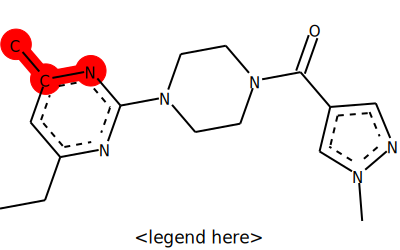

In [26]:
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from IPython.display import SVG
from rdkit.Chem.Draw.rdMolDraw2D import MolDrawOptions

m = Chem.MolFromSmiles('CCc1cc(C)nc(n1)N1CCN(CC1)C(=O)c1cnn(C)c1')
atoms = m.GetAtoms()

rdDepictor.Compute2DCoords(m)

matches=[4,5,6]

drawer = rdMolDraw2D.MolDraw2DSVG(400,250)

opts = drawer.drawOptions()
opts.padding = 0
opts.setHighlightColour((1, 0, 0))

for match in matches:
    opts.atomLabels[match]=atoms[match].GetSymbol()
#     opts.atomLabels[match]=atoms[match].GetSmarts()

# print(opts.getHighlightColour())
# opts.setSymbolColour((0, 0, 0))
# opts.useBWAtomPalette = 1
opts.legendFontSize = 17
opts.updateAtomPalette({7:(0,0,0), 8:(0,0,0), 9:(0,0,0), 10:(0,0,0)})
# opts.fillHighlights = 1

drawer.DrawMolecule(m, highlightAtoms=matches, 
                    highlightAtomRadii={4:0.5, 5:0.5, 6:0.5},
                    legend='<legend here>')
drawer.FinishDrawing()
svg = drawer.GetDrawingText().replace('svg:','')
SVG(svg)

In [72]:
svgs = []
regular_atom_color = (0,0,0)
highlight_color = (1, 0, 0)  # pure red
highlight_atom_size = 0.5
svg = None
i = 0

for smiles, matches, lgnd in zip(smiles_unique, substructure_matches, legend):
    # molecule and atoms
    m = Chem.MolFromSmiles(smiles)
    atoms = m.GetAtoms()
    # depictor
    rdDepictor.Compute2DCoords(m)
    # get drawer and set options
    drawer = None
    drawer = rdMolDraw2D.MolDraw2DSVG(400,400)
    opts = drawer.drawOptions()
#     opts.padding = 0
    opts.setHighlightColour(highlight_color)
    opts.legendFontSize = 17
    atom_indices = []
    for atom in atoms:
        atom_indices.append(atom.GetIdx())
        
#     print('atom_indices', atom_indices)
        
    palette = {atom_indx:regular_atom_color for atom_indx in atom_indices}
    
#     print('palette', palette)
#     print('matches', matches)
#     print('smiles', smiles)
#     print('legend', lgnd)
    
    opts.updateAtomPalette(palette)
    # set highlighted atom labels
    for match in matches:
        opts.atomLabels[match]=atoms[match].GetSymbol()
#     opts.atomLabels[match]=atoms[match].GetSmarts()
    atom_radii_dict = {match:highlight_atom_size for match in matches}
#     print('atom_radii_dict', atom_radii_dict)
    # draw a molecule
    drawer.DrawMolecule(m,
                    highlightAtoms=matches, 
                    highlightAtomRadii=atom_radii_dict,
#                     legend=lgnd
                       )
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText().replace('svg:','')
    svgs.append(SVG(svg))
    i += 1

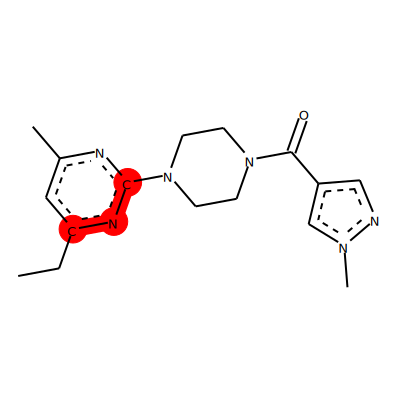

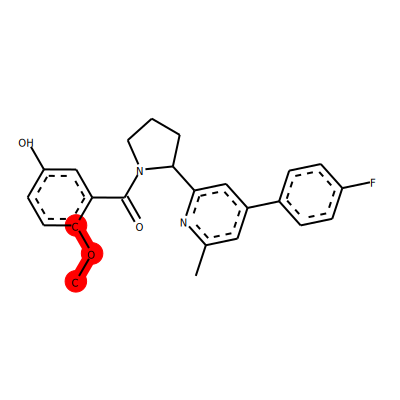

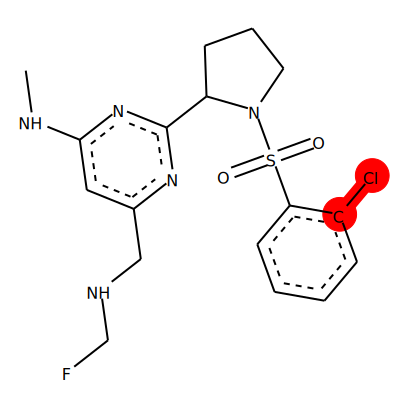

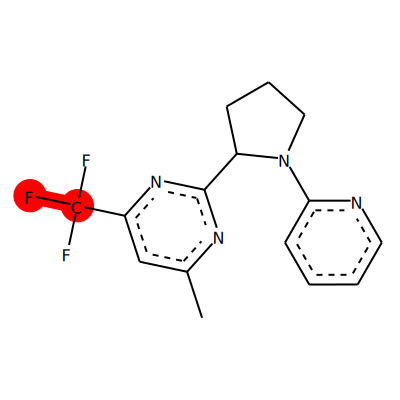

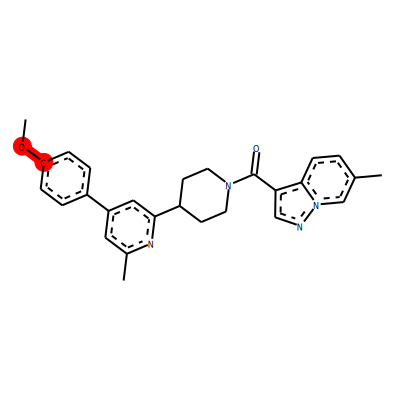

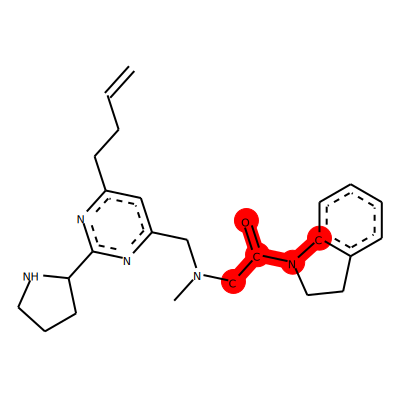

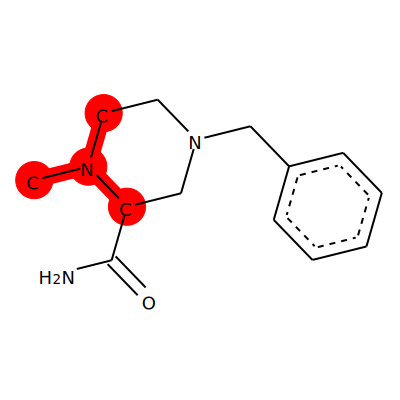

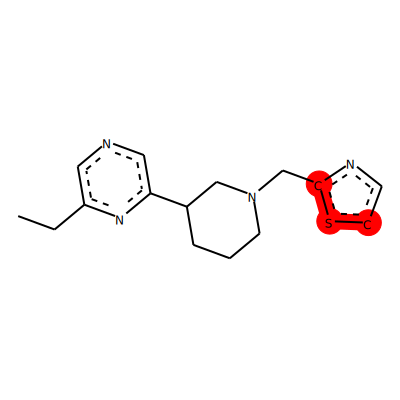

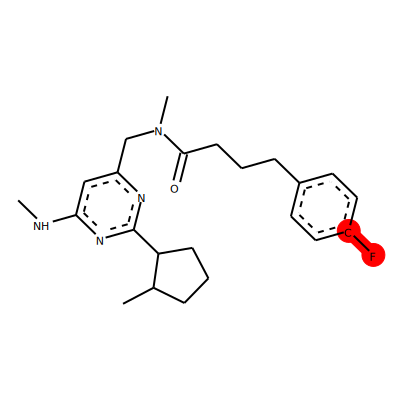

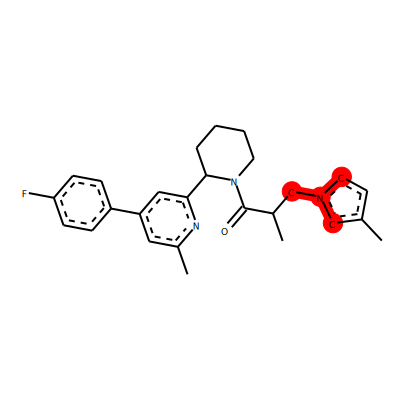

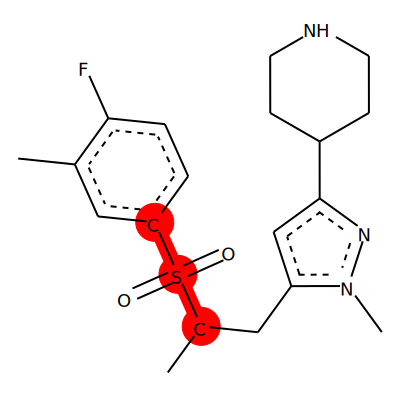

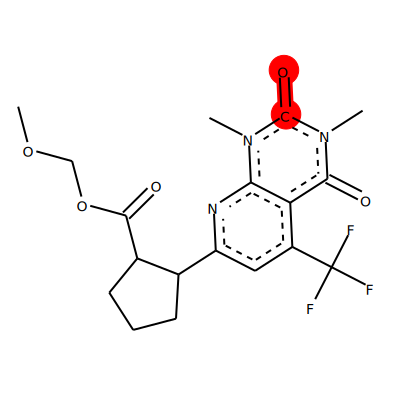

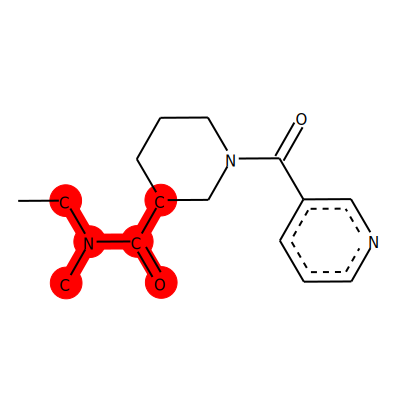

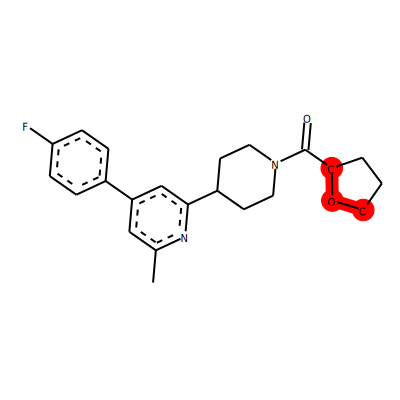

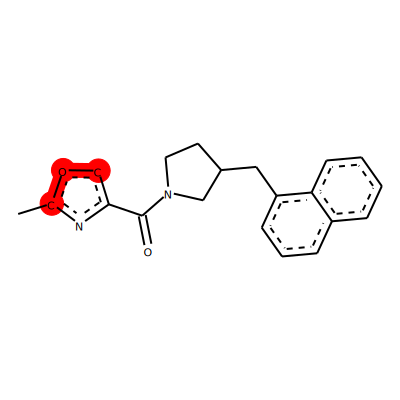

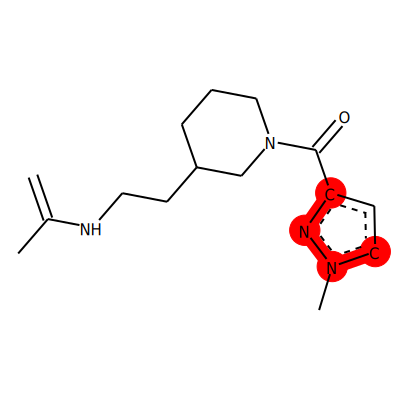

In [73]:
for svg in svgs:
    show_svg(svg)

In [30]:
print(len(svgs))

16


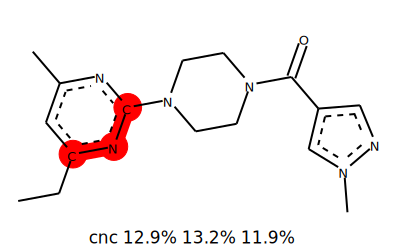

In [31]:
svgs[0]

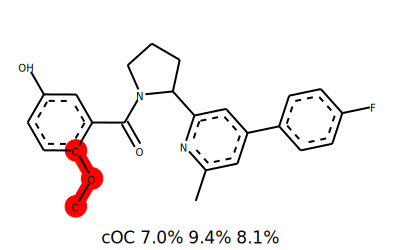

In [32]:
svgs[1]

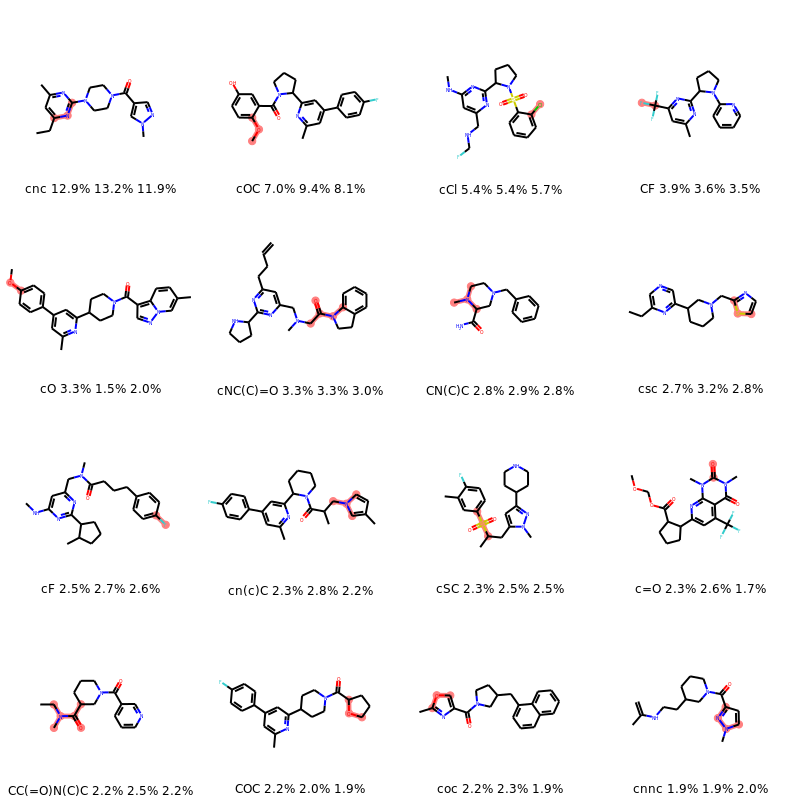

In [55]:
from rdkit.Chem.Draw.rdMolDraw2D import MolDrawOptions

regular_atom_color = (0,0,0)
highlight_color = (1, 0, 0)  # pure red
highlight_atom_size = 0.5

opts = MolDrawOptions()



# rdMolDraw2D.MolDraw2D.setDrawOptions(opts)

img = MolsToGridImage(mols, 
                molsPerRow=4, 
                legends=legend, 
                highlightAtomLists=substructure_matches,
#                 highlightBondColors=[(1,0,0)],
               )
img